# Best Subset Selection: L0-Regression

## Objective and Prerequisites

In this notebook you will:

1. Learn how to perform linear regression with feature selection using mathematical programming.
2. Gain insights about related approaches, such as OLS regression and the Lasso.

To fully understand the content of this notebook, the reader should be familiar with the following:

- Differential calculus.
- Linear algebra (matrix multiplication, transpose and inverse).
- Linear regression analysis.

---
## Motivation

Linear Regression was invented at the beginning of the 19th century and today, after more than 200 years, it is still used extensively in practical applications for description and prediction purposes:

- In econometrics, it is useful to estimate the price elasticity of a particular product by regressing sales revenue on price and possibly other features such as demographic, competitor and retail information.
- In health sciences, it can be applied to predict how long a patient will remain, i.e. length of stay, in the ER of a hospital based on patient information, triage assessment, medical test results and date/time of arrival.
- In social sciences, it may shed light on future academic performance of students, so proactive measures can be taken to improve their learning.

In general, Linear Regression is used to model the relationship between a continuous variable and other explanatory variables, which can be either continuous or categorical. When applying this technique, finding the subset of features that maximizes its perfomance is often of interest.

---
## Problem Description

Linear Regression is a supervised learning algorithm used to predict a quantitative response. It assumes that there is a linear relationship between the feature vector $x_i \in \mathbb{R}^d$ and the response $y_i \in \mathbb{R}$. Mathematically speaking, for sample $i$ we have $y_i = \beta^T x_i + \epsilon_i$, where $\beta \in \mathbb{R}^d$ is the vector of feature weights, including the intercept, and  $\epsilon_i$ is a normally-distributed random variable with zero mean and constant variance representing the error term. We can learn the weights from a training dataset with $n$ observations $\{X \in \mathbb{M}^{nxd},y \in \mathbb{R}^n\}$ by minimizing the Residual Sum of Squares (RSS): $e^Te =(y-X\beta)^T (y-X\beta)=\beta^T X^T X\beta- 2y^TX\beta+y^T y$. The Ordinary Least Squares (OLS) method achieves this by taking the derivative of this quadratic and convex function and then finding the stationary point: $\beta_{OLS}=(X^T X)^{-1} X^T y$.

In practice, some of the features are in fact not associated with the response. By including them, we only add unnecessary complexity to the model and increase variance to the weight estimates. However, finding the best performing model is no simple task as there is an exponential number of candidates, as one has to test $\sum_{s=1}^{d-1}{{d-1} \choose s}$ models. Since OLS rarely yields estimates that are exactly zero, thus discarding the features related to them, we need to resort to feature selection methods. Popular methods include:

- Subset selection, e.g. stepwise selection.
- Dimensionality reduction, e.g. principal component regression.
- Shrinkage, e.g. the Lasso.

The lasso has undoubtedly been the method of choice for the last decade. Basically it fits a model containing all $d$ predictors, while incorporating a budget constraint based on the L1-norm of $\beta$, disregarding the intercept component. In fact, this method minimizes the RSS, subject to $\sum_{l=1}^{d-1}\mathopen|\beta_l\mathclose| \leq s$, where $s$ is a hyper-parameter representing the budget that is usually tuned via cross-validation. This constraint has the effect of shrinking all weight estimates, allowing some of them to be exactly zero when $s$ is small enough. Finally, it is worth noting that the unconstrained version of the Lasso is more frequently used. This version solves an unconstrained optimization problem where $RSS + \lambda \sum_{l=1}^{d-1}\mathopen|\beta_l\mathclose|$ is minimized, for a given value of the —modified— lagrangian multiplier $\lambda \in \mathbb{R}^+$.  

A similar formulation is now presented, where the L0-norm is used instead. We now seek to minimize the RSS, subject to $\sum_{l=1}^{d-1}I(\beta_l \neq 0) \leq s$, where $I(\beta_l \neq 0)$ is an indicator function taking on the value of 1 if $\beta_j \neq 0$ and 0 otherwise. In this setting, $s$ represents the number of features to consider in the model. This optimization problem may be casted as a Mixed Integer Quadratic Program (MIQP). Traditionally, the feature selection problem has not been tackled this way because of the common belief in the statistics community that large scale problems are intractable. But this is no longer the case, considering the computing power currently available and the performance of modern optimization solvers such as Gurobi.

---
## Solution Approach

Mathematical programming is a declarative approach where the modeler formulates a mathematical optimization model that captures the key aspects of a complex decision problem. The Gurobi optimizer solves such models using state-of-the-art mathematics and computer science. 

A mathematical optimization model has five components, namely:

- Sets and indices.
- Parameters.
- Decision variables.
- Objective function(s).
- Constraints.

We now present a MIQP formulation that finds the weight estimates for a linear regression problem, where at most $s$ of those weights can be nonzero:

### Sets and Indices

$i \in I=\{1,2,\dots,n\}$: Set of observations.

$j \in J=\{1,2,\dots,d\}$: Set of features, where the last ID corresponds to the intercept.

$l \in L = J \backslash \{d\}$: Set of features, where the intercept is excluded.

### Parameters

$s \in \mathbb{N}$: Number of features to include in the model, ignoring the intercept.

$Q = X^T X \in \mathbb{M}^{|J|x|J|}$: Quadratic component of the objective function.

$c = y^TX \in \mathbb{R}^{|J|}$: Linear component of the objective function.

$k = y^T y \in \mathbb{R}$: Constant component of the objective function.

***Note:** Recall that the RSS is defined as $\beta^T X^T X\beta- 2y^TX\beta+y^T y$.

### Decision Variables

$\beta_j \in \mathbb{R}$: Weight of feature $j$, representing the change in the response variable per unit-change of feature $j$.

$iszero_l \in \{0,1\}$: 1 if weight of feature $l$ is exactly equal to zero, and 0 otherwise. Auxiliary variable used to manage the budget constraint.

### Objective Function

- **Training error**: Minimize the Residual Sum of Squares (RSS):

\begin{equation}
\text{Min} \quad Z = \frac{1}{2}\sum_{j \in J}\sum_{j' \in J}Q_{j,j'}\beta_j\beta_{j'} - \sum_{j \in J}c_j\beta_j + \frac{1}{2}k
\tag{0}
\end{equation}

Note that we use the fact that if $x^*$ is a minimizer of $f(x)$, it is also a minimizer of $a\cdot f(x)$, as long as $a > 0$.

### Constraints

- **Mutual exclusivity**: For each feature $l$, if $iszero_l=1$, then $\beta_l=0$ (defined as a Special Ordered Set of type one):

\begin{equation}
(\beta_l, iszero_l): \text{SOS-1} \quad \forall l \in L
\tag{1}
\end{equation}

- **Budget constraint**: Exactly $|L| - s$ feature weights must be equal to zero:

\begin{equation}
\sum_{l \in L}iszero_l \geq |L| - s
\tag{2}
\end{equation}

This model, by means of constraint 2, implicitly considers all ${{d-1} \choose s}$ feature subsets at once. Notice that it defines the budget constraint as $\sum_{l=1}^{d-1}I(\beta_l \neq 0) = s$, provided that the training RSS decreases monotonically as more features are considered. Because of this, we need to adjust the number of features via cross-validation, using the Mean Square Error (MSE) as the performance metric.

---
## Python Implementation

In the following implementation, we make use of four main libraries:

- **Numpy** for scientific computing.
- **Scikit learn** for machine learning algorithms.
- **Gurobi** for mathematical optimization.
- **Matplotlib** for visualization.

In [1]:
# Let's import all the necessary libraries

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from gurobipy import *
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
# Create and deploy the optimization model

# NOTE: This function assumes the design matrix features does not contain
#a column for the intercept
def miqp(features, response, non_zero, warm_up=None, verbose=False):
    """
    Deploy and optimize the MIQP formulation of L0-Regression.
    """
    assert isinstance(non_zero, (int, np.integer))
    regressor = Model()
    samples, dim = features.shape
    assert samples == response.shape[0]
    assert non_zero <= dim

    # Append a column of ones to the feature matrix to account for the y-intercept
    X = np.concatenate([features, np.ones((samples, 1))], axis=1)  
    
    # Decision variables
    beta = regressor.addVars(dim + 1, lb=-GRB.INFINITY, name="beta") # Weights
    intercept = beta[dim] # Last decision variable captures the y-intercept
    intercept.varname = 'intercept'
    # iszero[i] = 1 if beta[i] = 0  
    iszero = regressor.addVars(dim, vtype=GRB.BINARY, name="iszero") 
    
    # Objective Function (OF): minimize 1/2 * RSS using the fact that
    # if x* is a minimizer of f(x), it is also a minimizer of k*f(x) iff k > 0
    Quad = np.dot(X.T, X)
    lin = np.dot(response.T, X)
    obj = sum(0.5 * Quad[i,j] * beta[i] * beta[j]
              for i, j in product(range(dim + 1), repeat=2))
    obj -= sum(lin[i] * beta[i] for i in range(dim + 1))
    obj += 0.5 * np.dot(response, response)
    regressor.setObjective(obj, GRB.MINIMIZE)
    
    # Constraint sets
    for i in range(dim):
        # If iszero[i]=1, then beta[i] = 0
        regressor.addSOS(GRB.SOS_TYPE1, [beta[i], iszero[i]])
    regressor.addConstr(iszero.sum() >= dim - non_zero) # Budget constraint

    # We may use the Lasso or prev solution with fewer features as warm start
    if warm_up is not None and len(warm_up) == dim:
        for i in range(dim):
            iszero[i].start = (abs(warm_up[i]) < 1e-6)
    
    if not verbose:
        regressor.params.OutputFlag = 0
    regressor.params.timelimit = 60
    regressor.params.mipgap = 0.001
    regressor.optimize()

    coeff = np.array([beta[i].X for i in range(dim)])
    return intercept.X, coeff     

In [3]:
# Define functions necessary to perform hyper-parameter tuning via cross-validation

def split_folds(features, response, train_mask):
    """
    Assign folds to either train or test partitions based on train_mask.
    """
    xtrain = features[train_mask,:]
    xtest = features[~train_mask,:]
    ytrain = response[train_mask]
    ytest = response[~train_mask]
    return xtrain, xtest, ytrain, ytest

def cross_validate(features, response, non_zero, folds, seed):
    """
    Train an L0-Regression for each fold and report the cross-validated MSE.
    """
    if seed is not None:
        np.random.seed(seed)
    samples, dim = features.shape
    assert samples == response.shape[0]
    fold_size = int(np.ceil(samples / folds))
    # Randomly assign each sample to a fold
    shuffled = np.random.choice(samples, samples, replace=False)
    mse_cv = 0
    # Exclude folds from training, one at a time, 
    #to get out-of-sample estimates of the MSE
    for fold in range(folds):
        idx = shuffled[fold * fold_size : min((fold + 1) * fold_size, samples)]
        train_mask = np.ones(samples, dtype=bool)
        train_mask[idx] = False
        xtrain, xtest, ytrain, ytest = split_folds(features, response, train_mask)
        intercept, beta = miqp(xtrain, ytrain, non_zero)
        ypred = np.dot(xtest, beta) + intercept
        mse_cv += mse(ytest, ypred) / folds
    # Report the average out-of-sample MSE
    return mse_cv

def L0_regression(features, response, folds=5, seed=None):
    """
    Select the best L0-Regression model by performing grid search on the budget.
    """
    dim = features.shape[1]
    best_mse = np.inf
    best = 0
    # Grid search to find best number of features to consider
    for i in range(1, dim + 1):
        val = cross_validate(features, response, i, folds=folds, seed=seed)
        if val < best_mse:
            best_mse = val
            best = i
    intercept, beta = miqp(features, response, best)
    return intercept, beta

---
## Benchmark

We now compare the performance of the aforementioned approach w.r.t. OLS regression on all features and the Lasso. The Boston dataset is used for this purpose. This dataset measures the prices of 506 houses, along with 13 features that provide insights about their neighbourhoods. We will use the original feature terminology, so the interested reader is referred to [this website](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

Note that 20% of the samples are reserved for computing the out-of-sample MSE. The resulting metrics are displayed in a bar chart (shown below) to facilitate the comparison between models.

In [4]:
# Define how the bar chart should be displayed

def plot_bar_chart(performance):
    """
    Display the performance of all three models in a bar chart.
    """
    bar = plt.bar([1, 2, 3], performance, color=['r', 'g', 'y'],
                  tick_label=['OLS', 'Lasso', 'L0-Regression'])
    plt.title('Out-of-Sample MSE')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, np.floor(np.min(performance)),
              np.ceil(np.max(performance))))
    plt.show()

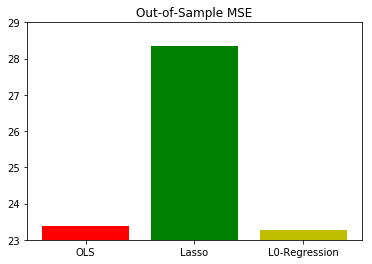

In [5]:
# Load data and split into train (80%) and test (20%)
boston = load_boston()
X = boston['data']
y = boston['target']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20,
                                                random_state=10101)

# OLS regression using all features
lr = linear_model.LinearRegression()
lr.fit(Xtrain, ytrain)
# Lasso with cross-validated penalization (lambda)
lasso = linear_model.LassoCV(cv=5)
lasso.fit(Xtrain, ytrain)
# L0-regression where the best feature subset is selected via cross-validation
intercept, beta = L0_regression(Xtrain, ytrain, seed=10101)

# Compare their performance using a bar chart
performance = []
performance.append(mse(ytest, lr.predict(Xtest)))
performance.append(mse(ytest, lasso.predict(Xtest)))
performance.append(mse(ytest, np.dot(Xtest, beta) + intercept))
plot_bar_chart(performance)

Notice that the Lasso performs poorly, as we did not standardized the features to be expressed in the same units (with an average of zero and variance of one). Contrary to OLS and L0-Regression, the Lasso is not scale-invariant because the budget constraint is based on the L1-norm. Remember that $\beta_l$ is interpreted as the change in the response per unit-change of feature $l$. Since the L1-norm takes the sum of absolute values, how much of the budget $\beta_l$ consumes depends on the units of measurement of the feature associated to it. 

Let's now see the results when the features are preprocessed. Such preprocessing entails three steps, namely:

For each feature $x_l$:
1. Compute its sample average $\mu_l$ and sample standard deviation $\sigma_l$.
2. Center by subtracting $\mu_l$ from $x_l$.
3. Scale by dividing the resulting difference by $\sigma_l$. 

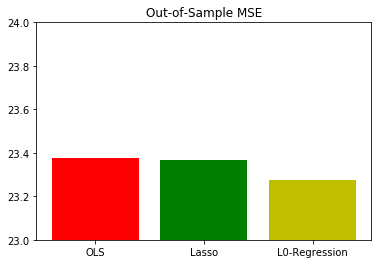

In [6]:
# Standardize the features so they have an avg of 0 and a sample var of 1
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

# OLS regression using all features
lr = linear_model.LinearRegression()
lr.fit(Xtrain, ytrain)
# Lasso with cross-validated penalization (lambda)
lasso = linear_model.LassoCV(cv=5)
lasso.fit(Xtrain, ytrain)
# L0-regression where the best feature subset is selected via cross-validation
intercept, beta = L0_regression(Xtrain, ytrain, seed=10101)

# Compare their performance using a Bar chart
performance = []
performance.append(mse(ytest, lr.predict(Xtest)))
performance.append(mse(ytest, lasso.predict(Xtest)))
performance.append(mse(ytest, np.dot(Xtest, beta) + intercept))
plot_bar_chart(performance)

As expected, the Lasso is better (although marginally) than OLS. This is due to the fact that the Lasso can retrieve the $\beta_{OLS}$ estimate when the budget $s$ is big enough (alternatively, when $\lambda$ is small enough). On the other hand, it is marginally worse than L0-regression, mainly because by shrinking $\beta$ we add bias to the estimates. Furthermore, observe that L0-regression achieved the best performance with the fewest number of features. This is convenient, as it leads to a more interpretable model.

In [7]:
ols_features = np.sum(np.abs(lr.coef_) >= 1e-8)
lasso_features = np.sum(np.abs(lasso.coef_) >= 1e-8)
l0_features = np.sum(np.abs(beta) >= 1e-8)
print("OLS regression kept {0} features.".format(ols_features))
print("The Lasso kept {0} features.".format(lasso_features))
print("L0-regression kept {0} features.".format(l0_features))

OLS regression kept 13 features.
The Lasso kept 12 features.
L0-regression kept 11 features.


### Final Model

The previous analysis indicates that the best candidate is the model suggested by L0-regression. The resulting equation is as follows:

\begin{equation}
\text{medv} = 22.56-1.02\text{crim}+1.46\text{zn}+0.49\text{chas}-1.93\text{nox}+2.53\text{rm}
\end{equation}

\begin{equation}
-3.48\text{dis}+2.65\text{rad}-2.22\text{tax}-1.87\text{ptratio}+1.00\text{b}-3.69\text{lstat}
\end{equation}

Since we standardized the data, the intercept represents the estimated median value (in thousands) of a house with mean values across features. Likewise, we can interpret $\beta_1=-1.02$ as the decrease in the house value when the per-capita crime rate increases by one standard deviation from the average value, all other thing being equal (similar statements can be made for the rest of the features). Finally, if the main purpose of the analysis is to explain the variability in the response, having 11 features may be too much. However, remember that one can always set the number of active features to a more manageable number to ease the interpretation, perhaps at the expense of predictive power.

---
## Conclusion

It has been shown how mathematical programming can be used to perform feature selection on linear regression problems. It is in fact a good alternative to the Lasso, given that L0-regression is scale invariant and does not add bias to the weight estimates. Furthermore, this approach is amenable to the specification of additional linear constraints (Bertsimas, 2015), such as:

- Enforcing group sparsity among features.
- Limiting pairwise multicollinearity.
- Limiting global multicollinearity.
- Considering a fixed set of nonlinear transformations.

Nevertheless, take this result with caution, as "there is no free lunch in statistics". That is, no algorithm outperforms all others under all possible datasets. Ultimately, a good data scientist should consider multiple learning algorithms when analyzing a dataset.

---
## References

1. Bertsimas, D., & King, A. (2015). OR forum—An algorithmic approach to linear regression. Operations Research, 64(1), 2-16.
2. Bertsimas, D., King, A., & Mazumder, R. (2016). Best subset selection via a modern optimization lens. The annals of statistics, 44(2), 813-852.
3. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning. New York: springer.
4. The Boston housing dataset (1996, October 10). Retrieved from https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

Copyright © 2019 Gurobi Optimization, LLC